In [ ]:
# base libraries
import os
import librosa
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa.display
from IPython import display
from tabulate import tabulate
import matplotlib.pyplot as plt

# pytorch
import torch
import torchaudio
import torch.nn as nn
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

# sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split

# jupyter notebook configuration
%matplotlib inline
warnings.filterwarnings('ignore')

# Read the data

In [ ]:
# google disc path
data_path = '/content/drive/MyDrive/UrbanSound8K'
audio_path = '/content/drive/MyDrive/UrbanSound8K/audio/'

# Read metadata file
metadata_file = data_path + '/metadata/UrbanSound8K.csv'
df = pd.read_csv(metadata_file)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
print(f'metadata shape: {df.shape}')

metadata shape: (8732, 8)


In [ ]:
# exctract values
files = df["slice_file_name"].values.tolist()
folds = df["fold"].values
labels = df["classID"].values.tolist()

# Spectogram

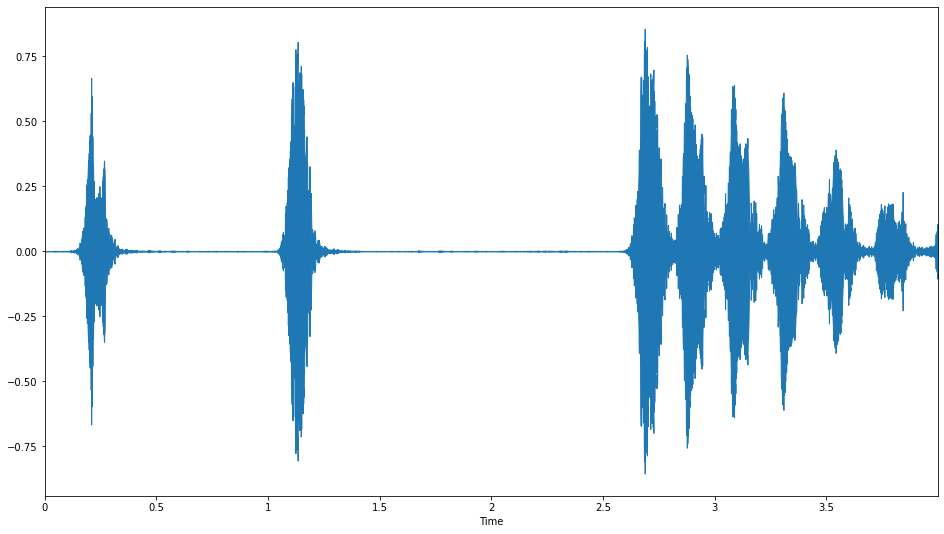

In [ ]:
name = '/content/drive/MyDrive/UrbanSound8K/audio/fold1/101415-3-0-2.wav'  
data, sampling_rate = librosa.load(name)

plt.figure(figsize=(16, 9))
librosa.display.waveplot(data, sr=sampling_rate)

# play sound
display.Audio(data, rate=sampling_rate)

Text(0.5, 1.0, 'Power spectrogram')

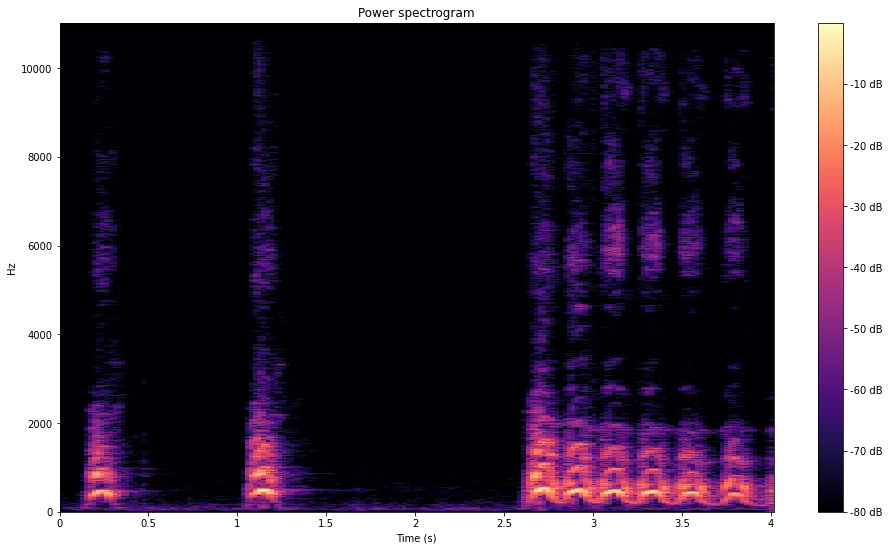

In [ ]:
# harmonic Mel spectogram
plt.figure(figsize=(16, 9))
db = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(db, y_axis='linear', x_axis='s')
plt.colorbar(format='%+2.0f dB')
plt.title('Power spectrogram')

Shape: (20, 173)


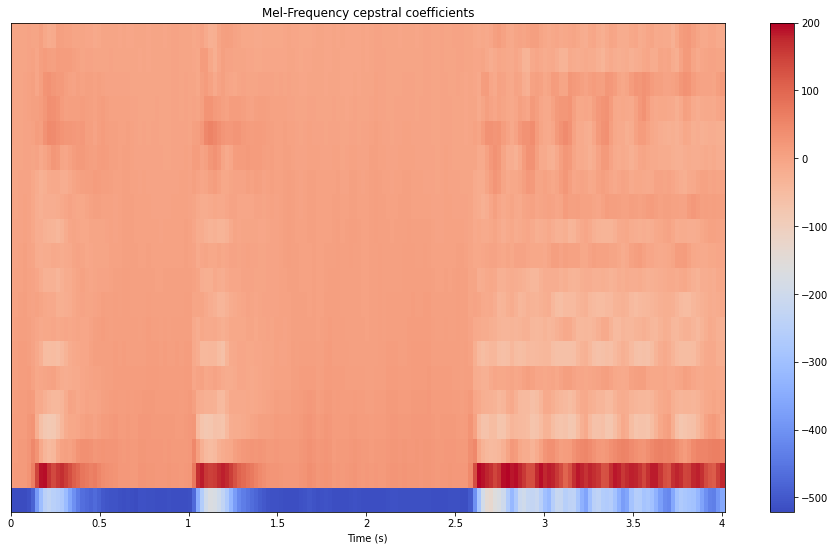

In [ ]:
mfcc=librosa.feature.mfcc(data, sr=sampling_rate)
print("Shape:", mfcc.shape)

plt.figure(figsize=(16, 9))
librosa.display.specshow(mfcc, x_axis="s")
plt.title("Mel-Frequency cepstral coefficients")
plt.colorbar()

# Define Custom Data Loader

In [ ]:
class SundDS(Dataset):
    def __init__(self, path, class_id):
        self.path = path
        self.class_id = class_id
        self.sr = 44100

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        path = self.path[idx]

        # load audio
        waveform, sr = torchaudio.load(path, normalize=True)

        # convert sterio to mono
        mono = torch.mean(waveform, dim=0, keepdim=True)

        data = torch.zeros([1, self.sr])

        if mono.numel() < self.sr:
            data[:, :mono.numel()] = mono
        else:
            data = mono[:, :self.sr]

        mel_specgram = torchaudio.transforms.MelSpectrogram(sr)(data)

        # normalization
        mel_specgram_norm = (
            mel_specgram - mel_specgram.mean()) / mel_specgram.std()

        mfcc = torchaudio.transforms.MFCC(sample_rate=sr)(data)

        # normalization
        mfcc_norm = (mfcc - mfcc.mean()) / mfcc.std()

        features = torch.cat([mel_specgram_norm, mfcc_norm], axis=1)

        return {"spec": torch.tensor(features[0].permute(1, 0), dtype=torch.float),
                "label": torch.tensor(self.class_id[idx], dtype=torch.long)}

# Prepare Batches of Data with the Data Loader

In [ ]:
# create path with training data
path = [os.path.join(audio_path + "fold" + str(folder) + "/" + file)
        for folder, file in zip(folds, files)]

X_train, X_test, y_train, y_test = train_test_split(
    path, labels, random_state=42, test_size=0.25)

In [ ]:
# create custom datasets
train, test = SundDS(X_train, y_train), SundDS(X_test, y_test)


def collate_fn(data):
    labels, specs = [], []
    for d in data:
        spec = d["spec"].to(device)
        label = d["label"].to(device)
        specs.append(spec)
        labels.append(label)

    spec = torch.nn.utils.rnn.pad_sequence(
        specs, batch_first=True, padding_value=0.)
    labels = torch.tensor(labels)

    return spec, labels


train_loader = torch.utils.data.DataLoader(
    train, batch_size=32, shuffle=False, drop_last=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(
    test, batch_size=32, shuffle=False, drop_last=True, collate_fn=collate_fn)

# Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, classes=10, n_feature=168, n_hidden=128, n_layers=1, drop=0.2):
        super().__init__()
        self.drop = drop
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = n_feature
        self.lstm = nn.LSTM(self.n_feature, self.n_hidden,
                            self.n_layers, dropout=self.drop, batch_first=True)
        self.dropout = nn.Dropout(drop)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(int(n_hidden), int(n_hidden/2))
        self.fc2 = nn.Linear(int(n_hidden/2), classes)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        return hidden

In [ ]:
# check GPU and cuda are working
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Fri Dec 24 20:21:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# train and save
def train(data_loader, model, epoch, optimizer, device):
    losses, labels, preds = [], [], []
    train_accuracies = []

    model.train()

    # progress bar
    loop = tqdm(data_loader)  
    for batch_idx, (data, target) in enumerate(loop):
        # load data to gpu
        data = data.to(device)
        target = target.to(device)

        # zero out the gradients
        model.zero_grad()
        output, hidden_state = model(data, model.init_hidden(32))

        # loss function
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # softmax
        probs = torch.softmax(output, dim=1)
        pred = probs.argmax(dim=1)
        true_pred = pred == target

        # claculate accuracy of the calculations
        accuracy = true_pred.sum().float() / float(target.size(0))
        train_accuracies.append(accuracy)

        labels += torch.flatten(target).cpu()
        preds += torch.flatten(pred).cpu()

        loop.set_description(
            f"EPOCH: {epoch} | ITERATION : {batch_idx} / {len(data_loader)} | LOSS: {loss.item()} | ACCURACY: {accuracy}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = sum(losses) / len(losses)
    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    report = metrics.classification_report(
        torch.tensor(labels).numpy(), torch.tensor(preds).numpy())
    print(report)

    return avg_train_loss, avg_train_accuracy

In [ ]:
# inference
def test(data_loader, model, optimizer, device):
    model.eval()
    accs, preds, labels = [], [], []
    test_accuracies = []

    with torch.no_grad():
        # loss function
        loop = tqdm(data_loader)

        for batch_idx, (data, target) in enumerate(loop):
            data = data.to(device)
            target = target.to(device)

            output, hidden_state = model(data, model.init_hidden(32))

            # softmax
            probs = torch.softmax(output, dim=1)
            pred = probs.argmax(dim=1)
            corrects = pred == target

            # claculate accuracy of the calculations
            accuracy = corrects.sum().float() / float(target.size(0))
            test_accuracies.append(accuracy)

            labels += torch.flatten(target).cpu()
            preds += torch.flatten(pred).cpu()

    avg_test_acc = sum(test_accuracies) / len(test_accuracies)

    return avg_test_acc

# Training

In [ ]:
EPOCHS = 20

writer = SummaryWriter()

model = LSTM().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3)

best_train_acc, best_epoch = 0, 0 

for epoch in range(EPOCHS):
    avg_train_loss, avg_train_acc = train(train_loader, model, epoch, optimizer, device)
    avg_test_acc = test(test_loader, model, optimizer, device)
    
    scheduler.step(avg_train_acc)
    if avg_train_acc > best_train_acc:
        best_train_acc = avg_train_acc
        best_epoch = epoch
        filename = f"Best model (epoch: {best_epoch})."
        checkpoint = {"model_state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}

        # save torch maodel
        save_model = lambda state, filename: torch.save(state, filename)
        save_model(checkpoint, filename)
    
    table = [["avg_train_loss", avg_train_loss], ["avg_train_accuracy", avg_train_acc],
             ["best_train_acc", best_train_acc], ["best_epoch", best_epoch]]
    
    # tabulate representation
    print(tabulate(table))

    test_table = [["Avg. test accuracy", avg_test_acc]]

    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Accuracy/Train', avg_train_acc, epoch)
    writer.add_scalar('Accuracy/Test', avg_test_acc, epoch)

    # tabulate representation
    print(tabulate(test_table)) 

print('Finish!')

EPOCH: 0 | ITERATION : 203 / 204 | LOSS: 1.499008297920227 | ACCURACY: 0.5625: 100%|██████████| 204/204 [26:52<00:00,  7.90s/it, loss=1.5]


              precision    recall  f1-score   support

           0       0.28      0.43      0.34       748
           1       0.43      0.13      0.20       326
           2       0.27      0.12      0.17       764
           3       0.38      0.54      0.44       751
           4       0.57      0.46      0.51       740
           5       0.36      0.38      0.37       755
           6       0.45      0.06      0.11       280
           7       0.44      0.52      0.48       732
           8       0.45      0.62      0.52       701
           9       0.35      0.28      0.31       731

    accuracy                           0.39      6528
   macro avg       0.40      0.35      0.34      6528
weighted avg       0.39      0.39      0.37      6528



100%|██████████| 68/68 [08:19<00:00,  7.35s/it]


------------------  --------
avg_train_loss      1.71401
avg_train_accuracy  0.387102
best_train_acc      0.387102
best_epoch          0
------------------  --------
------------------  --------
Avg. test accuracy  0.494945
------------------  --------


EPOCH: 1 | ITERATION : 203 / 204 | LOSS: 1.5055809020996094 | ACCURACY: 0.53125: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=1.51]


              precision    recall  f1-score   support

           0       0.40      0.49      0.44       748
           1       0.53      0.35      0.42       326
           2       0.43      0.30      0.35       764
           3       0.45      0.54      0.49       751
           4       0.68      0.56      0.61       740
           5       0.49      0.52      0.51       755
           6       0.44      0.40      0.42       280
           7       0.61      0.68      0.64       732
           8       0.63      0.68      0.65       701
           9       0.41      0.40      0.40       731

    accuracy                           0.51      6528
   macro avg       0.51      0.49      0.49      6528
weighted avg       0.51      0.51      0.50      6528



100%|██████████| 68/68 [00:38<00:00,  1.75it/s]


------------------  --------
avg_train_loss      1.40104
avg_train_accuracy  0.505974
best_train_acc      0.505974
best_epoch          1
------------------  --------
------------------  --------
Avg. test accuracy  0.453125
------------------  --------


EPOCH: 2 | ITERATION : 203 / 204 | LOSS: 1.6031078100204468 | ACCURACY: 0.53125: 100%|██████████| 204/204 [02:01<00:00,  1.67it/s, loss=1.6]


              precision    recall  f1-score   support

           0       0.44      0.54      0.49       748
           1       0.51      0.44      0.47       326
           2       0.43      0.36      0.39       764
           3       0.51      0.54      0.52       751
           4       0.69      0.60      0.64       740
           5       0.56      0.56      0.56       755
           6       0.53      0.51      0.52       280
           7       0.65      0.70      0.67       732
           8       0.62      0.68      0.65       701
           9       0.47      0.43      0.45       731

    accuracy                           0.54      6528
   macro avg       0.54      0.54      0.54      6528
weighted avg       0.54      0.54      0.54      6528



100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


------------------  --------
avg_train_loss      1.30451
avg_train_accuracy  0.541667
best_train_acc      0.541667
best_epoch          2
------------------  --------
------------------  --------
Avg. test accuracy  0.581342
------------------  --------


EPOCH: 3 | ITERATION : 203 / 204 | LOSS: 1.2988933324813843 | ACCURACY: 0.59375: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=1.3]


              precision    recall  f1-score   support

           0       0.48      0.54      0.51       748
           1       0.54      0.48      0.51       326
           2       0.44      0.38      0.41       764
           3       0.58      0.60      0.59       751
           4       0.73      0.61      0.67       740
           5       0.58      0.63      0.60       755
           6       0.63      0.69      0.66       280
           7       0.68      0.72      0.70       732
           8       0.66      0.70      0.68       701
           9       0.47      0.44      0.46       731

    accuracy                           0.58      6528
   macro avg       0.58      0.58      0.58      6528
weighted avg       0.58      0.58      0.58      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  --------
avg_train_loss      1.21928
avg_train_accuracy  0.576746
best_train_acc      0.576746
best_epoch          3
------------------  --------
------------------  --------
Avg. test accuracy  0.615349
------------------  --------


EPOCH: 4 | ITERATION : 203 / 204 | LOSS: 1.0662509202957153 | ACCURACY: 0.625: 100%|██████████| 204/204 [02:02<00:00,  1.67it/s, loss=1.07]


              precision    recall  f1-score   support

           0       0.56      0.62      0.59       748
           1       0.57      0.55      0.56       326
           2       0.49      0.46      0.48       764
           3       0.65      0.64      0.65       751
           4       0.75      0.67      0.71       740
           5       0.62      0.63      0.63       755
           6       0.75      0.74      0.74       280
           7       0.72      0.77      0.74       732
           8       0.74      0.78      0.76       701
           9       0.52      0.51      0.51       731

    accuracy                           0.63      6528
   macro avg       0.64      0.64      0.64      6528
weighted avg       0.63      0.63      0.63      6528



100%|██████████| 68/68 [00:38<00:00,  1.75it/s]


------------------  --------
avg_train_loss      1.094
avg_train_accuracy  0.632659
best_train_acc      0.632659
best_epoch          4
------------------  --------
------------------  --------
Avg. test accuracy  0.659007
------------------  --------


EPOCH: 5 | ITERATION : 203 / 204 | LOSS: 1.0846738815307617 | ACCURACY: 0.5: 100%|██████████| 204/204 [02:03<00:00,  1.65it/s, loss=1.08]


              precision    recall  f1-score   support

           0       0.58      0.72      0.64       748
           1       0.62      0.55      0.58       326
           2       0.55      0.53      0.54       764
           3       0.66      0.64      0.65       751
           4       0.78      0.71      0.74       740
           5       0.68      0.70      0.69       755
           6       0.79      0.78      0.79       280
           7       0.77      0.80      0.79       732
           8       0.79      0.77      0.78       701
           9       0.56      0.52      0.54       731

    accuracy                           0.67      6528
   macro avg       0.68      0.67      0.67      6528
weighted avg       0.67      0.67      0.67      6528



100%|██████████| 68/68 [00:38<00:00,  1.75it/s]


------------------  --------
avg_train_loss      0.986235
avg_train_accuracy  0.671109
best_train_acc      0.671109
best_epoch          5
------------------  --------
------------------  --------
Avg. test accuracy  0.670496
------------------  --------


EPOCH: 6 | ITERATION : 203 / 204 | LOSS: 0.8757707476615906 | ACCURACY: 0.6875: 100%|██████████| 204/204 [02:03<00:00,  1.66it/s, loss=0.876]


              precision    recall  f1-score   support

           0       0.64      0.73      0.68       748
           1       0.64      0.63      0.63       326
           2       0.57      0.55      0.56       764
           3       0.69      0.67      0.68       751
           4       0.79      0.71      0.74       740
           5       0.72      0.75      0.73       755
           6       0.79      0.85      0.82       280
           7       0.81      0.83      0.82       732
           8       0.82      0.80      0.81       701
           9       0.59      0.58      0.59       731

    accuracy                           0.70      6528
   macro avg       0.70      0.71      0.71      6528
weighted avg       0.70      0.70      0.70      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  --------
avg_train_loss      0.890347
avg_train_accuracy  0.701593
best_train_acc      0.701593
best_epoch          6
------------------  --------
------------------  --------
Avg. test accuracy  0.695312
------------------  --------


EPOCH: 7 | ITERATION : 203 / 204 | LOSS: 1.0061628818511963 | ACCURACY: 0.53125: 100%|██████████| 204/204 [02:04<00:00,  1.64it/s, loss=1.01]


              precision    recall  f1-score   support

           0       0.67      0.73      0.70       748
           1       0.66      0.64      0.65       326
           2       0.56      0.58      0.57       764
           3       0.71      0.67      0.69       751
           4       0.80      0.75      0.78       740
           5       0.73      0.78      0.75       755
           6       0.86      0.84      0.85       280
           7       0.84      0.86      0.85       732
           8       0.82      0.79      0.81       701
           9       0.59      0.56      0.58       731

    accuracy                           0.72      6528
   macro avg       0.72      0.72      0.72      6528
weighted avg       0.72      0.72      0.72      6528



100%|██████████| 68/68 [00:38<00:00,  1.74it/s]


------------------  --------
avg_train_loss      0.834315
avg_train_accuracy  0.716605
best_train_acc      0.716605
best_epoch          7
------------------  --------
------------------  --------
Avg. test accuracy  0.712316
------------------  --------


EPOCH: 8 | ITERATION : 203 / 204 | LOSS: 0.7876870036125183 | ACCURACY: 0.75: 100%|██████████| 204/204 [02:03<00:00,  1.66it/s, loss=0.788]


              precision    recall  f1-score   support

           0       0.71      0.77      0.74       748
           1       0.73      0.69      0.71       326
           2       0.59      0.60      0.59       764
           3       0.73      0.71      0.72       751
           4       0.82      0.77      0.80       740
           5       0.76      0.81      0.78       755
           6       0.88      0.87      0.87       280
           7       0.86      0.85      0.85       732
           8       0.85      0.82      0.83       701
           9       0.62      0.61      0.61       731

    accuracy                           0.74      6528
   macro avg       0.75      0.75      0.75      6528
weighted avg       0.74      0.74      0.74      6528



100%|██████████| 68/68 [00:38<00:00,  1.75it/s]


------------------  --------
avg_train_loss      0.775965
avg_train_accuracy  0.743719
best_train_acc      0.743719
best_epoch          8
------------------  --------
------------------  --------
Avg. test accuracy  0.715993
------------------  --------


EPOCH: 9 | ITERATION : 203 / 204 | LOSS: 0.9874022603034973 | ACCURACY: 0.75: 100%|██████████| 204/204 [02:03<00:00,  1.65it/s, loss=0.987]


              precision    recall  f1-score   support

           0       0.73      0.82      0.77       748
           1       0.76      0.73      0.74       326
           2       0.63      0.63      0.63       764
           3       0.74      0.74      0.74       751
           4       0.85      0.80      0.82       740
           5       0.82      0.81      0.81       755
           6       0.89      0.91      0.90       280
           7       0.87      0.88      0.87       732
           8       0.87      0.83      0.85       701
           9       0.63      0.63      0.63       731

    accuracy                           0.77      6528
   macro avg       0.78      0.78      0.78      6528
weighted avg       0.77      0.77      0.77      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  --------
avg_train_loss      0.704444
avg_train_accuracy  0.769608
best_train_acc      0.769608
best_epoch          9
------------------  --------
------------------  --------
Avg. test accuracy  0.711857
------------------  --------


EPOCH: 10 | ITERATION : 203 / 204 | LOSS: 0.6360006332397461 | ACCURACY: 0.84375: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.636]


              precision    recall  f1-score   support

           0       0.76      0.81      0.79       748
           1       0.77      0.72      0.74       326
           2       0.63      0.64      0.64       764
           3       0.76      0.73      0.75       751
           4       0.82      0.82      0.82       740
           5       0.80      0.85      0.82       755
           6       0.90      0.87      0.88       280
           7       0.90      0.89      0.90       732
           8       0.89      0.85      0.87       701
           9       0.66      0.65      0.65       731

    accuracy                           0.78      6528
   macro avg       0.79      0.78      0.79      6528
weighted avg       0.78      0.78      0.78      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  ---------
avg_train_loss       0.664151
avg_train_accuracy   0.780178
best_train_acc       0.780178
best_epoch          10
------------------  ---------
------------------  --------
Avg. test accuracy  0.735754
------------------  --------


EPOCH: 11 | ITERATION : 203 / 204 | LOSS: 0.7212114930152893 | ACCURACY: 0.6875: 100%|██████████| 204/204 [02:03<00:00,  1.65it/s, loss=0.721]


              precision    recall  f1-score   support

           0       0.78      0.84      0.81       748
           1       0.79      0.77      0.78       326
           2       0.63      0.67      0.65       764
           3       0.78      0.73      0.75       751
           4       0.86      0.85      0.86       740
           5       0.84      0.86      0.85       755
           6       0.93      0.90      0.91       280
           7       0.92      0.92      0.92       732
           8       0.87      0.83      0.85       701
           9       0.68      0.67      0.67       731

    accuracy                           0.80      6528
   macro avg       0.81      0.80      0.81      6528
weighted avg       0.80      0.80      0.80      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  --------
avg_train_loss       0.60839
avg_train_accuracy   0.79856
best_train_acc       0.79856
best_epoch          11
------------------  --------
------------------  --------
Avg. test accuracy  0.756893
------------------  --------


EPOCH: 12 | ITERATION : 203 / 204 | LOSS: 0.6693492531776428 | ACCURACY: 0.78125: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.669]


              precision    recall  f1-score   support

           0       0.79      0.83      0.81       748
           1       0.76      0.78      0.77       326
           2       0.67      0.66      0.67       764
           3       0.78      0.75      0.77       751
           4       0.84      0.83      0.84       740
           5       0.83      0.86      0.84       755
           6       0.92      0.90      0.91       280
           7       0.91      0.86      0.89       732
           8       0.88      0.85      0.86       701
           9       0.66      0.70      0.68       731

    accuracy                           0.80      6528
   macro avg       0.80      0.80      0.80      6528
weighted avg       0.80      0.80      0.80      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  ---------
avg_train_loss       0.619659
avg_train_accuracy   0.796569
best_train_acc       0.79856
best_epoch          11
------------------  ---------
------------------  --------
Avg. test accuracy  0.669577
------------------  --------


EPOCH: 13 | ITERATION : 203 / 204 | LOSS: 0.8300939202308655 | ACCURACY: 0.65625: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.83]


              precision    recall  f1-score   support

           0       0.77      0.82      0.79       748
           1       0.79      0.77      0.78       326
           2       0.67      0.68      0.68       764
           3       0.79      0.74      0.76       751
           4       0.83      0.80      0.81       740
           5       0.81      0.83      0.82       755
           6       0.90      0.89      0.90       280
           7       0.82      0.86      0.84       732
           8       0.87      0.85      0.86       701
           9       0.67      0.67      0.67       731

    accuracy                           0.78      6528
   macro avg       0.79      0.79      0.79      6528
weighted avg       0.78      0.78      0.78      6528



100%|██████████| 68/68 [00:38<00:00,  1.75it/s]


------------------  ---------
avg_train_loss       0.646373
avg_train_accuracy   0.783395
best_train_acc       0.79856
best_epoch          11
------------------  ---------
------------------  --------
Avg. test accuracy  0.738971
------------------  --------


EPOCH: 14 | ITERATION : 203 / 204 | LOSS: 0.7855372428894043 | ACCURACY: 0.6875: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.786]


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       748
           1       0.85      0.81      0.83       326
           2       0.68      0.70      0.69       764
           3       0.80      0.77      0.78       751
           4       0.87      0.84      0.85       740
           5       0.84      0.87      0.85       755
           6       0.91      0.92      0.91       280
           7       0.90      0.91      0.91       732
           8       0.89      0.85      0.87       701
           9       0.72      0.70      0.71       731

    accuracy                           0.82      6528
   macro avg       0.82      0.82      0.82      6528
weighted avg       0.82      0.82      0.82      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  ---------
avg_train_loss       0.5503
avg_train_accuracy   0.815717
best_train_acc       0.815717
best_epoch          14
------------------  ---------
------------------  --------
Avg. test accuracy  0.756434
------------------  --------


EPOCH: 15 | ITERATION : 203 / 204 | LOSS: 0.4065874218940735 | ACCURACY: 0.875: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.407]


              precision    recall  f1-score   support

           0       0.85      0.88      0.87       748
           1       0.83      0.81      0.82       326
           2       0.71      0.71      0.71       764
           3       0.83      0.77      0.80       751
           4       0.89      0.89      0.89       740
           5       0.87      0.89      0.88       755
           6       0.92      0.91      0.92       280
           7       0.91      0.93      0.92       732
           8       0.88      0.87      0.88       701
           9       0.72      0.73      0.72       731

    accuracy                           0.83      6528
   macro avg       0.84      0.84      0.84      6528
weighted avg       0.83      0.83      0.83      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  ---------
avg_train_loss       0.496666
avg_train_accuracy   0.834559
best_train_acc       0.834559
best_epoch          15
------------------  ---------
------------------  --------
Avg. test accuracy  0.772059
------------------  --------


EPOCH: 16 | ITERATION : 203 / 204 | LOSS: 0.7260100841522217 | ACCURACY: 0.71875: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.726]


              precision    recall  f1-score   support

           0       0.87      0.88      0.87       748
           1       0.85      0.85      0.85       326
           2       0.72      0.74      0.73       764
           3       0.84      0.80      0.82       751
           4       0.89      0.89      0.89       740
           5       0.89      0.90      0.90       755
           6       0.94      0.93      0.93       280
           7       0.93      0.94      0.93       732
           8       0.90      0.87      0.89       701
           9       0.74      0.76      0.75       731

    accuracy                           0.85      6528
   macro avg       0.86      0.86      0.86      6528
weighted avg       0.85      0.85      0.85      6528



100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


------------------  ---------
avg_train_loss       0.463219
avg_train_accuracy   0.851256
best_train_acc       0.851256
best_epoch          16
------------------  ---------
------------------  -------
Avg. test accuracy  0.74954
------------------  -------


EPOCH: 17 | ITERATION : 203 / 204 | LOSS: 0.3377406895160675 | ACCURACY: 0.84375: 100%|██████████| 204/204 [02:03<00:00,  1.65it/s, loss=0.338]


              precision    recall  f1-score   support

           0       0.86      0.90      0.88       748
           1       0.85      0.83      0.84       326
           2       0.74      0.77      0.76       764
           3       0.84      0.80      0.82       751
           4       0.90      0.89      0.90       740
           5       0.88      0.90      0.89       755
           6       0.93      0.92      0.93       280
           7       0.93      0.94      0.93       732
           8       0.91      0.88      0.90       701
           9       0.75      0.74      0.75       731

    accuracy                           0.86      6528
   macro avg       0.86      0.86      0.86      6528
weighted avg       0.86      0.86      0.86      6528



100%|██████████| 68/68 [00:38<00:00,  1.75it/s]


------------------  ---------
avg_train_loss       0.424031
avg_train_accuracy   0.855086
best_train_acc       0.855086
best_epoch          17
------------------  ---------
------------------  --------
Avg. test accuracy  0.784467
------------------  --------


EPOCH: 18 | ITERATION : 203 / 204 | LOSS: 0.4714018404483795 | ACCURACY: 0.8125: 100%|██████████| 204/204 [02:03<00:00,  1.66it/s, loss=0.471]


              precision    recall  f1-score   support

           0       0.90      0.91      0.90       748
           1       0.90      0.88      0.89       326
           2       0.78      0.77      0.78       764
           3       0.86      0.81      0.84       751
           4       0.92      0.93      0.92       740
           5       0.89      0.90      0.90       755
           6       0.95      0.95      0.95       280
           7       0.94      0.96      0.95       732
           8       0.91      0.90      0.90       701
           9       0.77      0.80      0.78       731

    accuracy                           0.88      6528
   macro avg       0.88      0.88      0.88      6528
weighted avg       0.88      0.88      0.87      6528



100%|██████████| 68/68 [00:44<00:00,  1.51it/s]


------------------  ---------
avg_train_loss       0.371853
avg_train_accuracy   0.875
best_train_acc       0.875
best_epoch          18
------------------  ---------
------------------  --------
Avg. test accuracy  0.773438
------------------  --------


EPOCH: 19 | ITERATION : 203 / 204 | LOSS: 0.3406807780265808 | ACCURACY: 0.84375: 100%|██████████| 204/204 [02:07<00:00,  1.60it/s, loss=0.341]


              precision    recall  f1-score   support

           0       0.88      0.92      0.90       748
           1       0.89      0.88      0.89       326
           2       0.77      0.76      0.76       764
           3       0.84      0.81      0.82       751
           4       0.92      0.90      0.91       740
           5       0.90      0.92      0.91       755
           6       0.91      0.93      0.92       280
           7       0.93      0.94      0.93       732
           8       0.92      0.89      0.90       701
           9       0.76      0.79      0.78       731

    accuracy                           0.87      6528
   macro avg       0.87      0.87      0.87      6528
weighted avg       0.87      0.87      0.87      6528



100%|██████████| 68/68 [00:38<00:00,  1.75it/s]

------------------  ---------
avg_train_loss       0.390106
avg_train_accuracy   0.867647
best_train_acc       0.875
best_epoch          18
------------------  ---------
------------------  --------
Avg. test accuracy  0.785846
------------------  --------
Finish!


In [ ]:
# save model
torch.save(model.state_dict(), '/content/model/state_dict_model.pt')
torch.save(model, '/content/model/model.pth')